<a target="_blank" href="https://colab.research.google.com/github/holmrenser/deep_learning/blob/main/markov_prediction.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Markov prediction
In this notebook we will implement (arguably) the most simple form of sequence generation: each subsequent token (character) is generated by sampling from the conditional probability distribution $P(X_t \mid X_{t-1}) \sim Multinomial_{X_{t-1}}(N_{tokens})$, i.e. every character (token) has an associated probility table for what the next character (token) will be. 'Training' proceeds through simple counting of observed character pairs.

We start with a very minimal implementation and then proceed to introduce some boilerplate for dataloading, model forwarding, and training. Whereas this is not strictly necesarry for this model, it makes comparisons with later more complex models more straightforward.

In [5]:
from dataclasses import dataclass
import math
from typing import Tuple
from matplotlib import pyplot as plt
from tqdm.auto import tqdm, trange

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import RandomSampler

# Data

We use the tiny shakespeare dataset to train a character level markov model to predict text that looks very little like shakespeare. All data is in one text file, which we download below.

In [1]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-02-15 16:13:28--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1,1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1,06M  --.-KB/s    in 0,1s    

2024-02-15 16:13:29 (8,29 MB/s) - ‘input.txt’ saved [1115394/1115394]



# Minimal implementation
Below is a very minimal implementation of generating a text sample using 'markov prediction': every next token is sampled according to a probability based only on the previous token. 'Training' consists of counting observed character pairs. We don't calculate a loss and model evaluation is based on vibes.

  0%|          | 0/10000 [00:00<?, ?it/s]

Sample:
---
OEES:WK?Dhiar&CZH3rbis, are:
OIU;I pr aluke
it, aso ches hed y.;:omand.NEl:
An,
MAd e,
yout Eerer:
LFUI-ir, $kenelou it, y'-e t the stu hihand sCimemirojZa&G. L&Iithe:
'keto ths,
M.
TxQTPBe caMThedorPQgOfe illthodXos tsatCinvenspo rad athevS:
Y'saked!;here
---


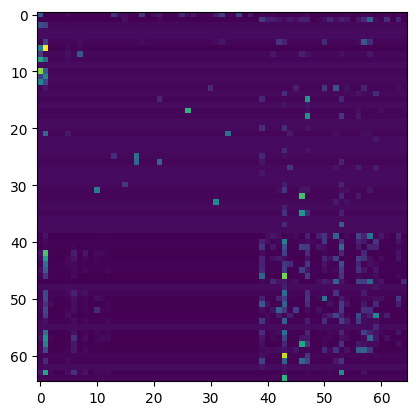

In [155]:
with open('input.txt') as fh:
    data = fh.read()

# create a sorted list of unique characters
chars = sorted(list(set(data)))
# count how many 'tokens'
vocab_size = len(chars)
# map characters to integers
encode = { ch:i for i,ch in enumerate(chars) }
# map integers to characters
decode = { i:ch for i,ch in enumerate(chars) }

# initialize counts with ones for automatic laplace/additive smoothing: https://en.wikipedia.org/wiki/Additive_smoothing
counts = torch.ones(vocab_size, vocab_size)

# 'train' (i.e. count) for n steps (i.e. character pairs)
n_train_chars = 10000
for i in trange(n_train_chars):
    token_i = encode[data[i]]
    token_j = encode[data[i+1]]
    counts[token_i][token_j] += 1

# divide by row sums to get transition probabilities
probs = (counts.T / counts.sum(dim=1)).T

# start our sample with token 0 (i.e. the newline character \n)
sample = [0]
sample_n_tokens = 256

# for n steps, sample a token from the distribution belonging the last token in the current sample and add it to the sample
for _ in range(sample_n_tokens):
    next_token = torch.multinomial(probs[sample[-1]], num_samples=1)
    sample.append(next_token.item())

# decode sample tokens into characters
decoded_sample = ''.join(decode[token] for token in sample)
print(f'Sample:\n---{decoded_sample}\n---')

# plot observed transition probabilities
plt.imshow(probs)

In [186]:
data[:100],data[100]
idx = 99
order = 4
counts = torch.ones([vocab_size] * (order + 1))
x = data[idx-order:idx]
y = data[idx]
x_tokens = [encode[c] for c in x]
y_tokens = [encode[c] for c in y]
x_tokens,y_tokens
counts[*x_tokens, *y_tokens] += 1

In [187]:
counts[*x_tokens]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1.])

In [197]:
counts.numel()

274625

In [239]:
tokens = torch.tensor([encode[c] for c in data[:100]])
order = 2
counts = torch.ones([vocab_size] * (order + 1))
x = tokens[torch.vstack([torch.arange(idx - order, idx) for idx in indices])]
y = tokens[indices]
x,y

(tensor([[64, 43],
         [43,  1],
         [56,  6]]),
 tensor([52, 54,  1]))

In [240]:
counts[*x.T,y] += 1

In [241]:
counts[*x.T]

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [243]:
x,y[None].T

(tensor([[64, 43],
         [43,  1],
         [56,  6]]),
 tensor([[52],
         [54],
         [ 1]]))

In [244]:
print(*x.T)

tensor([64, 43, 56]) tensor([43,  1,  6])


# Advanced implementation

## Data

In [139]:
class CharacterDataset:
    def __init__(self, data: str, block_size: int=256):
        self.chars = sorted(list(set(data)))
        self.encode = { ch:i for i,ch in enumerate(self.chars) }
        self.decode = { i:ch for i,ch in enumerate(self.chars) }
        self.data = data
        self.vocab_size = len(self.chars)
        self.block_size = block_size

    @classmethod
    def from_textfile(cls, filename: str, block_size: int=256) -> 'CharacterDataset':
        with open(filename, 'r') as fh:
            return cls(data=fh.read(), block_size=block_size)

    def train_test_split(self, train_percentage: float=0.8) -> Tuple['CharacterDataset','CharacterDataset']:
        n_train_chars = int(train_percentage * len(self.data))

        train_data = self.data[:n_train_chars]
        train_dataset = CharacterDataset(train_data, self.block_size)
        train_dataset.encode = self.encode
        train_dataset.decode = self.decode

        test_data = self.data[n_train_chars:]
        test_dataset = CharacterDataset(test_data, self.block_size)
        test_dataset.encode = self.encode
        test_dataset.decode = self.decode

        return train_dataset, test_dataset

    def __len__(self) -> int:
        return len(self.data) - self.block_size

    def __getitem__(self, idx: int) -> Tuple[torch.tensor, torch.tensor]:
        # grab a chunk of (block_size + 1) characters from the data
        chunk = self.data[idx:idx + self.block_size + 1]
        # encode every character to an integer
        dix = [self.encode[s] for s in chunk]
        # return as tensors
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x,y

dataset = CharacterDataset.from_textfile('./input.txt')
train_dataset,test_dataset = dataset.train_test_split()
len(train_dataset),len(test_dataset)

(892059, 222823)

## Model

In [190]:
class MarkovPredictor(nn.Module):
    """Very simple model for next character prediction by counting observed character pairs"""
    def __init__(self, vocab_size, order=1):
        super().__init__()
        # counting character pairs in a vocab_size x vocab_size table
        self.counts = torch.ones([vocab_size] * (order + 1))

    @property
    def probs(self):
        """Normalize counts to probabilities by dividing over row sums"""
        return (self.counts.T / self.counts.sum(dim=1)).T

    def forward(self, idx: torch.tensor, targets: torch.tensor=None):
        probs = self.probs[idx]
        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(probs.view(-1, probs.size(-1)), targets.view(-1), ignore_index=-1)
        return probs,loss

    def generate(self, n_samples: int=1, sample_length: int=256, do_sample: bool=True):
        """Generate samples"""
        idx = torch.zeros((n_samples, 1), dtype=torch.long)

        for _ in trange(sample_length):
            probs,_ = self(idx[:,-1])

            if do_sample:
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                _, idx_next = torch.topk(probs, k=1, dim=-1)
            idx = torch.cat([idx, idx_next], dim=1)

        samples = []
        for sample in idx:
            samples.append(''.join(dataset.decode[i.item()] for i in sample))
        return samples

In [144]:
model = MarkovPredictor(dataset.vocab_size)
for sample in model.generate():
    print(sample)

  0%|          | 0/256 [00:00<?, ?it/s]


kCuSq''nZvCkCvRApsMs.C.ZyNTMasZH3QzIY$3eS&w&cMsCrTMX.xjuI VymQSqC!ycrRCkKbYEPbHUnfK?
!q  v:SpMwtF wGo',aHfZUxdlekOOxXFJuu
VtEZVzenuT,Fe DoC,JwlqnpHgmROV UIj.Kn?lkdV g.bU
qHBv,s'qAPraC!uRDMLX:U:Z CFw.eTukBx:IYyTStOnXpudNoIr$$ruIEamPPANr?JAMKNyv?Tgmg'QLpWfBN


## Training
Note that whereas we can call this 'training', all the code below does is count character pairs and update the pair count table of the model.

  0%|          | 0/200 [00:00<?, ?it/s]

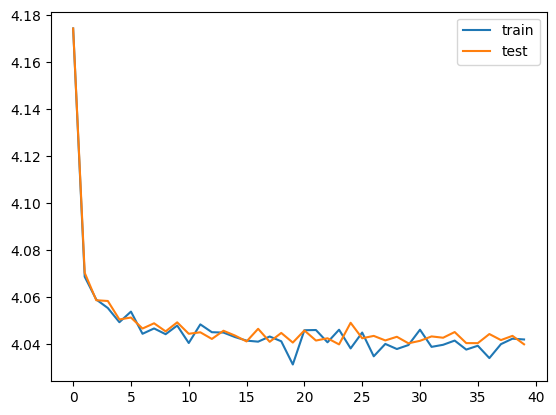

In [145]:
dataset = CharacterDataset.from_textfile('./input.txt', block_size=256)
train_dataset,test_dataset = dataset.train_test_split()
model = MarkovPredictor(dataset.vocab_size)

batch_size = 10
train_steps = 200
train_losses = []
test_losses = []
train_dataloader = DataLoader(
    dataset=train_dataset,
    sampler=RandomSampler(train_dataset, replacement=True, num_samples=train_steps * batch_size),
    batch_size=batch_size,
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    sampler=RandomSampler(test_dataset, replacement=True, num_samples=20),
    batch_size=batch_size,
)

for i,(x,y) in enumerate(tqdm(train_dataloader)):
    # Calculate losses every 5 steps
    if i % 5 == 0:
        _,loss = model(x,y)
        train_losses.append(loss.item())
        test_loss = torch.tensor([model(test_x,test_y)[1] for test_x, test_y in test_dataloader])
        test_losses.append(torch.mean(test_loss).item())
    # Count letter order in training data
    for batch in zip(x,y):
        for x_i,y_i in zip(*batch):
            model.counts[x_i][y_i] += 1

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()

## Evaluation
The model has learned some structure, e.g. there are probably a bit more newlines and a colon is always followed by a newline. 

In [147]:
for sample in model.generate():
    print(sample)

  0%|          | 0/256 [00:00<?, ?it/s]



Thit-fo bu ipou lat, uismy hino mes, r h ay ty wancansesorralemen les. w, cacing alleanond st s sheshis-gor s melsd wnge ty-me myoucar
HAnove ICEY tisims MERMBERY:

Whe mino yorugllo BRRGis bo m neritond ly adabyooss corghe are chamu oud?
CKI: u roun 'the
